In [1]:
# Calculating fisher information, ANALYTICALLY!! yippee. will this work? Who knows.

import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm

In [2]:
diameter = 0.125

# modifications to the wl range
wl_unc = 1

N = 1024              # number of samples
dx = 0.0008 * 10*10**(-9) # wavelength spacing, for ~ 1000 samples in 10 nm
# can just decrease the wavelength spacing...
fs = 1 / dx           # sampling frequency
freqs = np.fft.fftfreq(N, d=dx)

min_wavelength = 580e-9

max_wavelength = min_wavelength + dx*N

wl_bound = (max_wavelength - min_wavelength)*wl_unc

In [3]:
key = jr.PRNGKey(25)

# Create a complex array of zeros
spectrum = np.zeros(N, dtype=np.complex64)

# Random amplitudes and phases
amp_key, phase_key = jr.split(key)
random_amplitudes = jr.normal(amp_key, shape=(N,))
random_phases = jr.uniform(phase_key, shape=(N,), minval=0.0, maxval=2 * np.pi)

# Assign complex values
spectrum = random_amplitudes * np.exp(1j * random_phases)

# Make symmetric to ensure real time-domain signal
# Copy positive freqs into negative side
def make_hermitian(spec):
    spec = spec.at[1:N//2].set(spec[1:N//2])
    spec = spec.at[-(N//2)+1:].set(np.conj(spec[1:N//2][::-1]))
    return spec

spectrum = make_hermitian(spectrum)


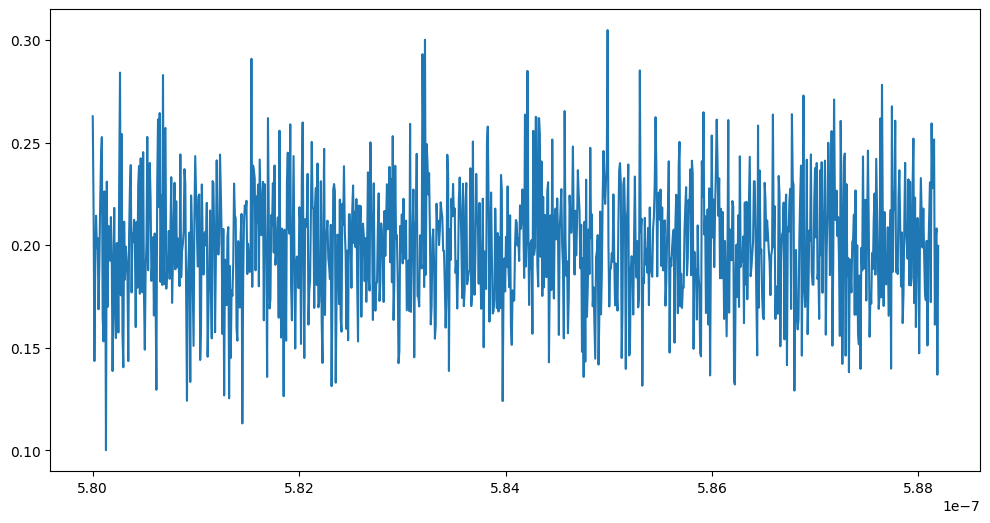

In [4]:
signal = np.fft.ifft(spectrum).real
# spectrum_filtered = spectrum.at[np.abs(freqs) > max_spec_freq].set(0)
# spectrum_filtered_low = spectrum.at[np.abs(freqs) > low_max_spec_freq].set(0)
# signal_filtered = np.fft.ifft(spectrum_filtered).real
# signal_filtered_low = np.fft.ifft(spectrum_filtered_low).real

if np.min(signal) <= 0:
    # signal_filtered += -2*np.min(signal)
    # signal_filtered_low += -2*np.min(signal)
    signal += -2*np.min(signal)

wavelengths = np.linspace(min_wavelength, max_wavelength, N)
plt.figure(figsize=(12,6))
plt.plot(wavelengths,signal)
plt.show()

In [59]:
# let's just do relatively low number of samples
sample_interval = 0.1e-9

n_wavelengths_sample = int(np.ceil((max_wavelength-min_wavelength+2*wl_bound)/sample_interval))

wavelengths_sample = np.linspace(min_wavelength - wl_bound, max_wavelength + wl_bound, n_wavelengths_sample)

weights_initial = np.ones(n_wavelengths_sample) # log weights, but init at 1

flux = 1e10

source = dl.PointSource(wavelengths, flux=flux, weights=signal)

source_model = dl.PointSource(wavelengths_sample, flux=flux, weights=weights_initial)

wf_npixels = 128 # 128 lowest power of 2 necessary

# circular aperture
# Construct a simple circular aperture
coords = dlu.pixel_coords(wf_npixels, diameter)
aperture = dlu.circle(coords, 0.5 * diameter)
# normalise = true
apertureLayer = dl.TransmissiveLayer(aperture, True)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 32

psf_pixel_scale = 0.375
oversample = 2 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)

telescope = dl.Telescope(optics, source)

telescope_model = dl.Telescope(optics, source_model)

psf = telescope.model()
psf_noise = jr.poisson(jr.PRNGKey(0), psf) #10*jr.normal(jr.PRNGKey(0), psf.shape) + psf

In [60]:
weights_path = 'source.spectrum.weights'

parameters = [weights_path]

model = telescope_model

# Optimisation
# 10% initial learning rate.
weights_optimiser = optax.adam(0.5)

optimisers = [weights_optimiser]

optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [61]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    # LOG WEIGHTS OPTIMISATION: THIS MAKES IT SOOOO MUCH BETTER!!!
    log_weights = model.get(weights_path)
    weights = np.exp(log_weights)
    model = model.set(weights_path, weights)
    out = model.model()
    # poisson log loss (very good stuff)
    # return np.sum((data-out)**2)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [62]:
losses, models_out = [], []
n_iter = 150
with tqdm(range(n_iter),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, psf_noise)

        updates, opt_state = optim.update(grads, opt_state)

        # just do log weight optimisation
        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Log Loss: 4.452: 100%|██████████| 150/150 [00:11<00:00, 12.74it/s]


In [63]:
model_log_weights = models_out[-1].weights
model_weights = np.exp(model_log_weights)
final_model = models_out[-1].set(weights_path, model_weights)
model_psf = final_model.model()

# extra wavelengths
N_extra = int(np.ceil(wl_bound/dx))
wl_extra_bound = N_extra*dx
wavelengths_extra = np.linspace(min_wavelength - wl_extra_bound, max_wavelength + wl_extra_bound, N + 2*N_extra)


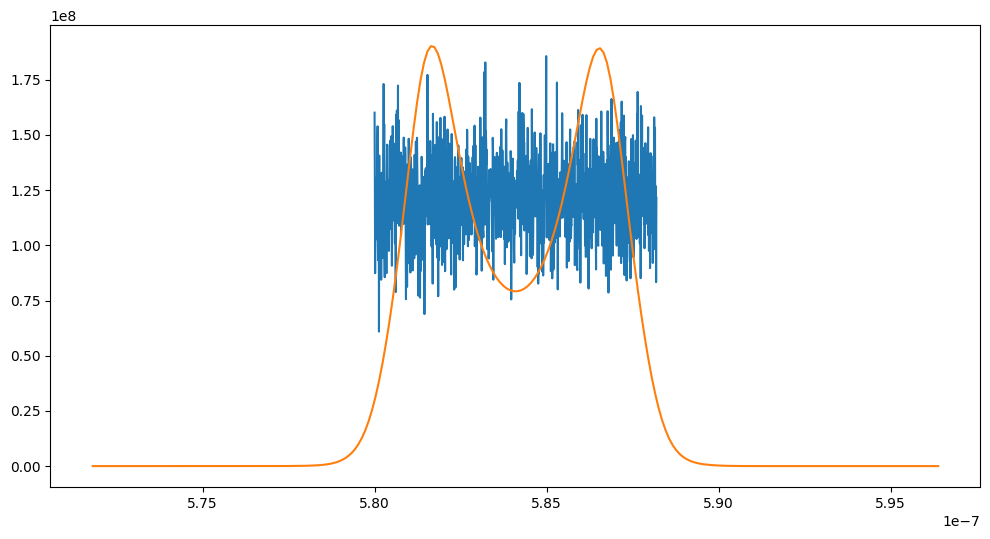

In [64]:
# signal norm, model norm
d_wl_signal = wavelengths[1]- wavelengths[0]
signal_norm = signal/(np.sum(signal)*d_wl_signal)
d_wl_model = wavelengths_sample[1] - wavelengths_sample[0]
model_norm = model_weights/(np.sum(model_weights)*d_wl_model)
plt.figure(figsize=(12,6))
plt.plot(wavelengths, signal_norm)
plt.plot(wavelengths_sample, model_norm)
plt.show()

In [65]:
print(len(wavelengths_sample))

246


In [66]:
# defining the mellin transform:,

def mellin_wavelengths(wavelengths, weights, freqs):
    

    d_wl = (wavelengths[1]-wavelengths[0])

    prefac = 1/np.sqrt(2*np.pi)

    mellin = np.zeros_like(freqs, dtype=np.complex64)
    for idx, freq in enumerate(freqs):
        mel = np.sum(weights * wavelengths**(1j * freq - 1) * d_wl)
        mellin = mellin.at[idx].set(mel)

    mellin *= prefac
    return mellin

In [67]:
max_freq = 200
freqs = np.linspace(-max_freq, max_freq, 1024)

signal_mel = mellin_wavelengths(wavelengths, signal_norm, freqs)
model_mel = mellin_wavelengths(wavelengths_sample, model_norm, freqs)

In [68]:
from scipy.special import loggamma


def h_kernel(freqs, diameter):
    logfisher = loggamma(1-1j*freqs/2) + loggamma(1/2 + 1j*freqs/2) - loggamma(1/2) - loggamma(3/2 - 1j*freqs/2) - loggamma(5/2 - 1j*freqs/2)

    prefac = (np.pi**(-1j*freqs) * diameter**(1-1j*freqs))/(2*np.sqrt(2*np.pi))

    fisher = np.exp(logfisher)

    fisher *= prefac
    return fisher

h_kern = h_kernel(freqs, diameter)

In [69]:
r_coords = dlu.pixel_coords(psf_npixels*oversample, dlu.arcsec2rad(psf_pixel_scale*psf_npixels),True)[0]

# factor I used before: *oversample*1.2745

In [70]:
from jax import vmap

def polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs, r0):
    p = np.log(r_coords/r0)

    prefac = 1/(r_coords)# NO FACTOR OF sqrt2pi,,, cancels because unitary fourier transform convolution theorem * np.sqrt(2*np.pi))
    d_freq = freqs[1] - freqs[0]

    def single_poly(pv):
        return np.sum(mellin_spec * h_hat * np.exp(-1.0j * freqs * pv) * d_freq)

    flat = vmap(single_poly)(p.ravel())
    polychrome = flat.reshape(r_coords.shape) * prefac
    return polychrome

# requires linear wavelenght distribution
# this ben popes implimentation of the bessel func of first kind
from jax.scipy.special import j1

def polyairydisk(r_coords, wavelengths, norm_weights, diameter):
    d_wl = wavelengths[1] - wavelengths[0]
    def single_wavelength(r):
        return np.sum(norm_weights * (1/wavelengths**2) * np.pi * diameter**2 * (j1(np.pi*diameter*r/wavelengths))**2/(np.pi*diameter*r/wavelengths)**2 * d_wl)
    
    flat = vmap(single_wavelength)(r_coords.ravel())
    polyairy = flat.reshape(r_coords.shape)

    return polyairy


In [71]:
psf_analytic = polyairydisk(r_coords, wavelengths, signal_norm, diameter)

In [72]:
# total r integral
# max_r = np.sqrt(2)*dlu.arcsec2rad(psf_pixel_scale)*psf_npixels/2
# or why not just
max_r = np.max(r_coords)

n_rs = 64
rs_int = np.linspace(max_r/n_rs,max_r,n_rs)

def inverse_nu_integral(rs_int, wavelengths, norm_weights, diameter):
    d_r = rs_int[1] - rs_int[0]

    inuint = np.sum(1/(rs_int*polyairydisk(rs_int, wavelengths, norm_weights, diameter)) * d_r)

    return inuint

inv_nu_int = inverse_nu_integral(rs_int, wavelengths, signal_norm, diameter)

fisher_info = (2 * np.pi) * np.abs(h_kern)**2 * inv_nu_int * flux

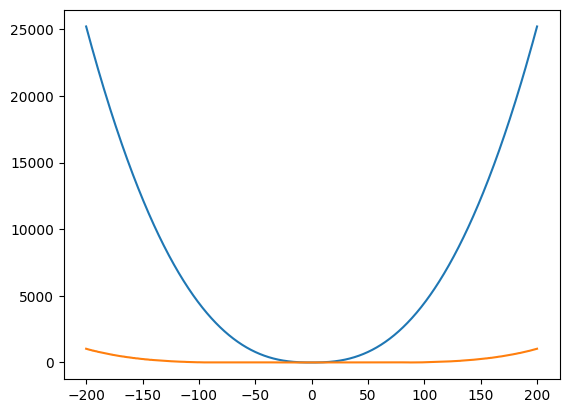

In [73]:
# plt.plot(freqs, np.abs(signal_mel))
# plt.plot(freqs, np.abs(model_mel))
# plotting cramer rao bound
plt.plot(freqs, 1/np.sqrt(fisher_info))

# plotting error between original mellin spectrum and recovered mellin spectrum
plt.plot(freqs, np.abs(np.abs(signal_mel)-np.abs(model_mel)))

# cramer rao bound shoots way higher than the errors.
#plt.xlim(-100,100)
#plt.ylim(0,700000)
plt.show()

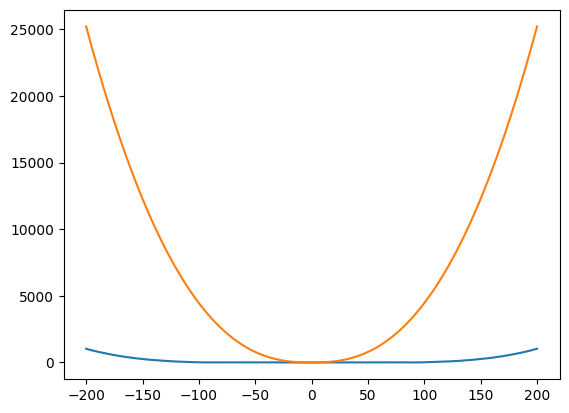

In [74]:
plt.plot(freqs, np.abs(np.abs(signal_mel)-np.abs(model_mel)))
plt.plot(freqs, 1/np.sqrt(fisher_info))
#plt.ylim(0,7e3)
#plt.plot(freqs, np.real(model_mel))

In [91]:
shape_dict= {'source.weights':(5,)}
from dLuxToliman import AlphaCen

source2 = AlphaCen()

alpha_model = dl.Telescope(optics, source2)

cov = zdx.self_covariance_matrix(alpha_model, ['source.weights'], zdx.bayes.poiss_loglike, shape_dict=shape_dict)
cov2 = zdx.covariance_matrix(alpha_model, ['source.weights'], zdx.bayes.poiss_loglike, alpha_model.model(), shape_dict=shape_dict)

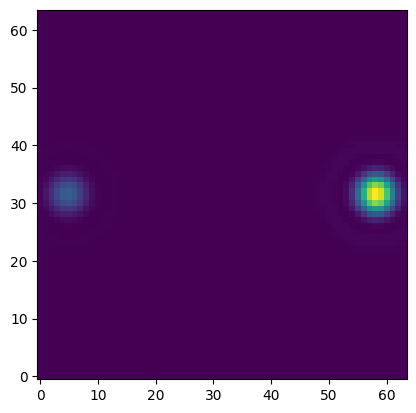

In [92]:
plt.imshow(alpha_model.model(),origin='lower')
plt.show()

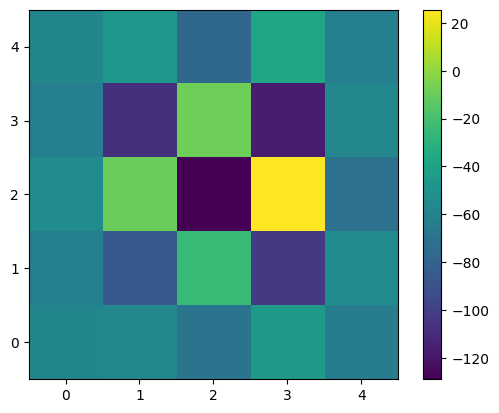

In [93]:
plt.imshow(cov2, origin='lower')
plt.colorbar()

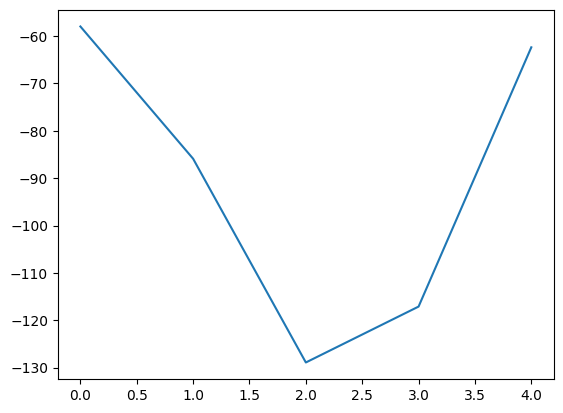

In [94]:
plt.plot(np.diag(cov))

In [25]:
print(n_wavelengths_sample)

246
